# Correlation between the historical context and dominant emotions

In [21]:
!pip install plotly

   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
    --------------------------------------- 0.3/19.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/19.1 MB 1.0 MB/s eta 0:00:18
   - -------------------------------------- 0.8/19.1 MB 1.2 MB/s eta 0:00:16
   - -------------------------------------- 0.8/19.1 MB 1.2 MB/s eta 0:00:16
   -- ------------------------------------- 1.0/19.1 MB 914.5 kB/s eta 0:00:20
   -- ------------------------------------- 1.3/19.1 MB 1.0 MB/s eta 0:00:18
   --- ------------------------------------ 1.6/19.1 MB 1.0 MB/s eta 0:00:18
   --- ------------------------------------ 1.8/19.1 MB 1.1 MB/s eta 0:00:16
   ---- ----------------------------------- 2.1/19.1 MB 1.2 MB/s eta 0:00:15
   ---- ----------------------------------- 2.4/19.1 MB 1.1 MB/s eta 0:00:15
   ----- ---------------------------------- 2.6/19.1 MB 1.1 MB/s eta 0:00:15
   ----- ---------

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
DATA_PATH = "../../../ada_projet/emotions_interpolated_20.pkl"
DATA_PATH_FILM = "../../../ada_projet/final_dataset.pkl"


In [6]:
with open(DATA_PATH, 'rb') as f:
    df = pickle.load(f)
df.head(2)

with open(DATA_PATH_FILM, 'rb') as f:
    df_film = pickle.load(f)
df_countries = df_film[["Wikipedia_movie_ID", "Movie_countries","continent","category","Movie_release_date"]]
df_countries.head(10)

Wikipedia_movie_ID                           Movie_countries  \
1                 3333                  United States of America   
2                 3746       United States of America, Hong Kong   
3                 3837                  United States of America   
4                 3947                  United States of America   
5                 4227  United States of America, United Kingdom   
6                 4231                  United States of America   
7                 4560                  United States of America   
8                 4726  United States of America, United Kingdom   
9                 4728  United States of America, United Kingdom   
10                4729  United States of America, United Kingdom   

        continent                                           category  \
1   North America                          [Action/Adventure, Drama]   
2   North America                  [Drama, Fantasy/Sci-Fi, Thriller]   
3   North America                         [Action/Adventure, Comedy]   
4   North America                                         [Thriller]   
5   North America                                   [Drama, Romance]   
6   North America                 [Action/Adventure, Comedy, Horror]   
7   North America                          [Action/Adventure, Drama]   
8   North America                [Action/Adventure, Drama, Thriller]   
9   North America       [Action/Adventure, Fantasy/Sci-Fi, Thriller]   
10  North America  [Action/Adventure, Comedy, Fantasy/Sci-Fi, Thr...   

    Movie_release_date  
1                  NaN  
2               1982.0  
3               1974.0  
4                  NaN  
5               1975.0  
6               1992.0  
7               1995.0  
8               1989.0  
9               1992.0  
10              1997.0

In [7]:
df_merged = pd.merge(df, df_countries, on="Wikipedia_movie_ID", how="inner")
df_merged.set_index("Wikipedia_movie_ID", inplace=True)

# Normalize emotion scores
emotion_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
#df_merged[emotion_columns] = df_merged[emotion_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
# Explode the "category" column to separate rows if a movie has multiple categories
df_exploded = df_merged.explode("category")
# Group by "continent", "category", and "timestep" to analyze emotions by continent and genre over time
df_groupy_by_continent = df_exploded.groupby(["continent", "category", "timestep"])[emotion_columns].mean()


In [8]:
# Assign individual DataFrames to variables for each continent for easy access
africa_df =  df_groupy_by_continent.xs('Africa', level='continent')
asia_df = df_groupy_by_continent.xs('Asia', level='continent')
europe_df = df_groupy_by_continent.xs('Europe', level='continent')
na_df = df_groupy_by_continent.xs('North America', level='continent')
oceania_df = df_groupy_by_continent.xs('Oceania', level='continent')
sa_df = df_groupy_by_continent.xs('South America', level='continent')

# Create a list containing all the continent-specific DataFrames for convenience
dfs = [africa_df, asia_df, europe_df, na_df, oceania_df, sa_df]

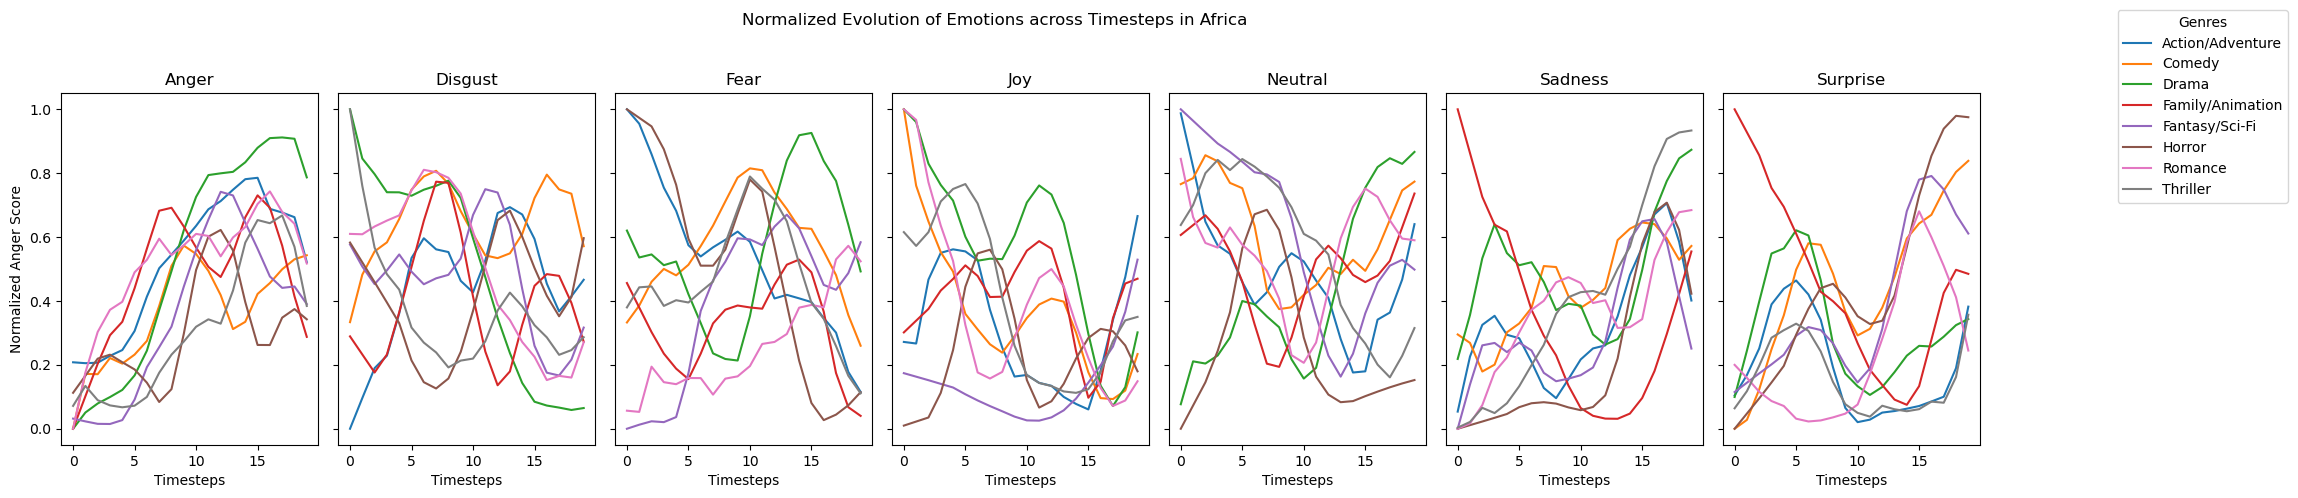

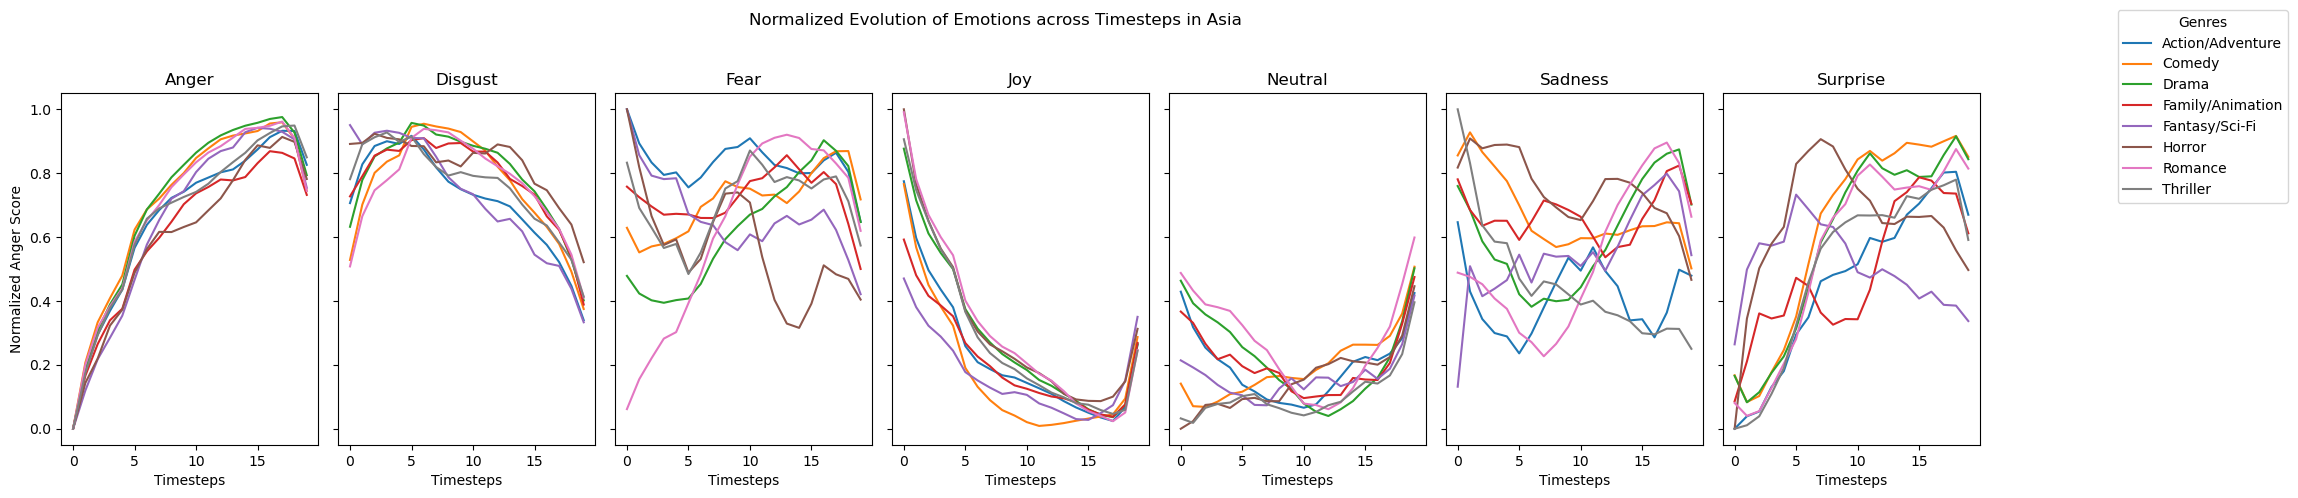

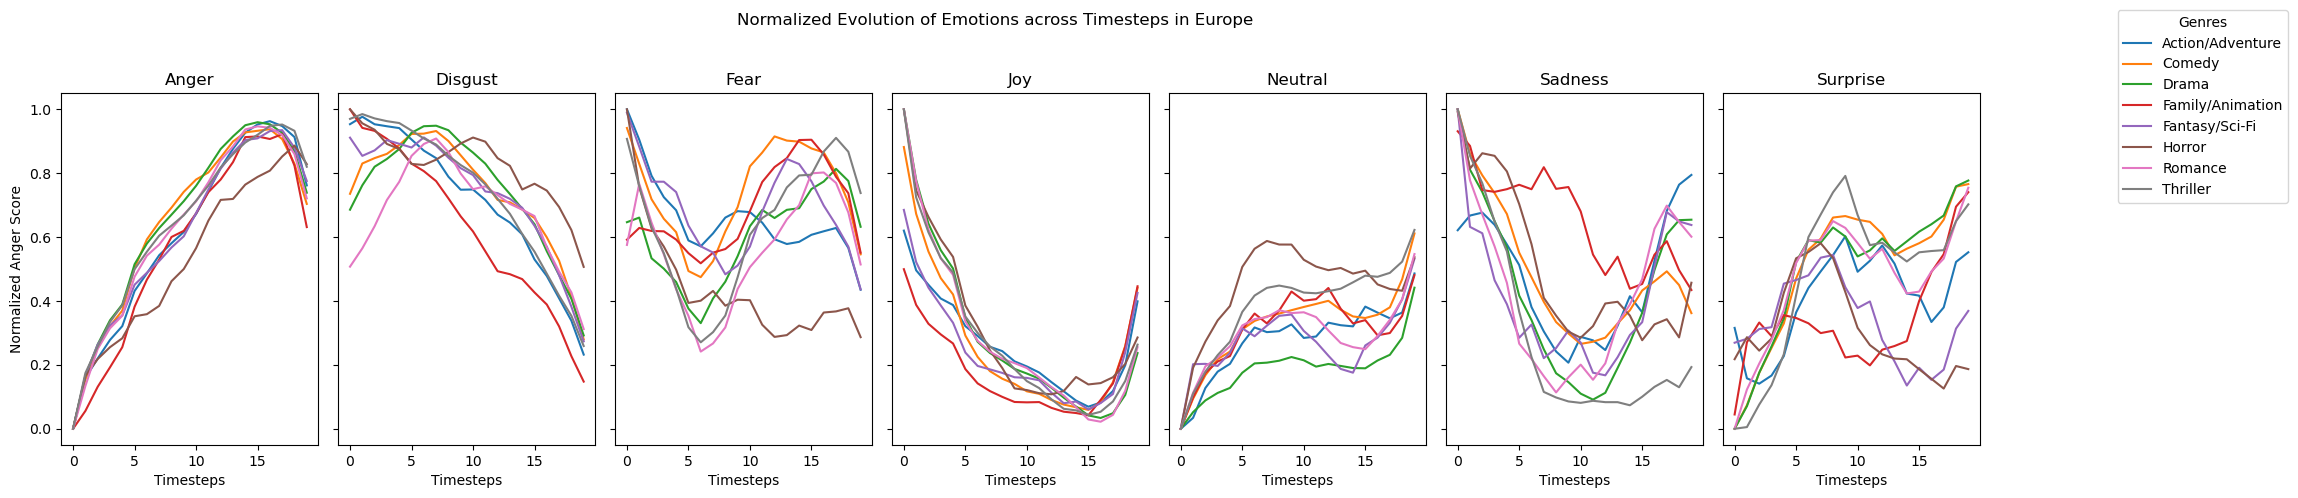

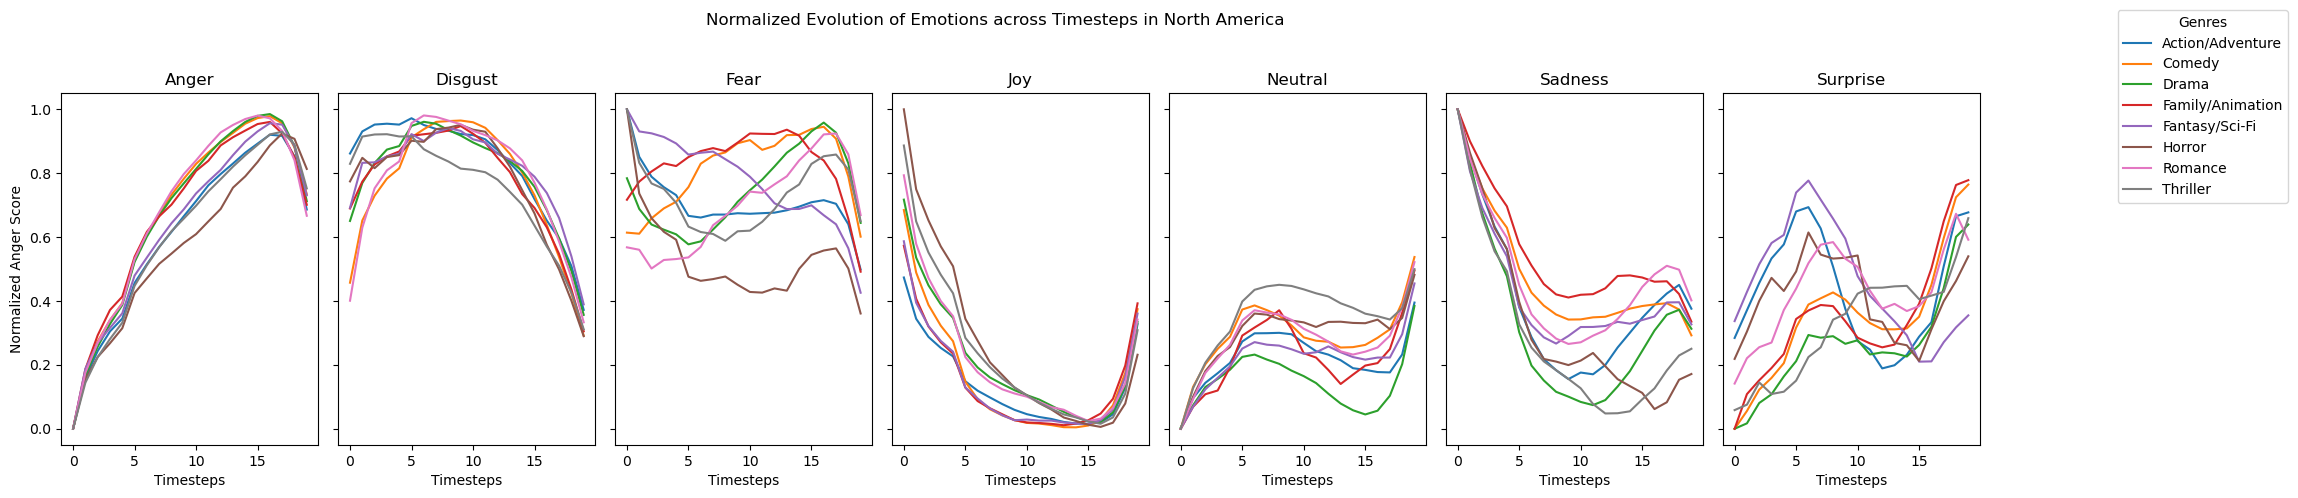

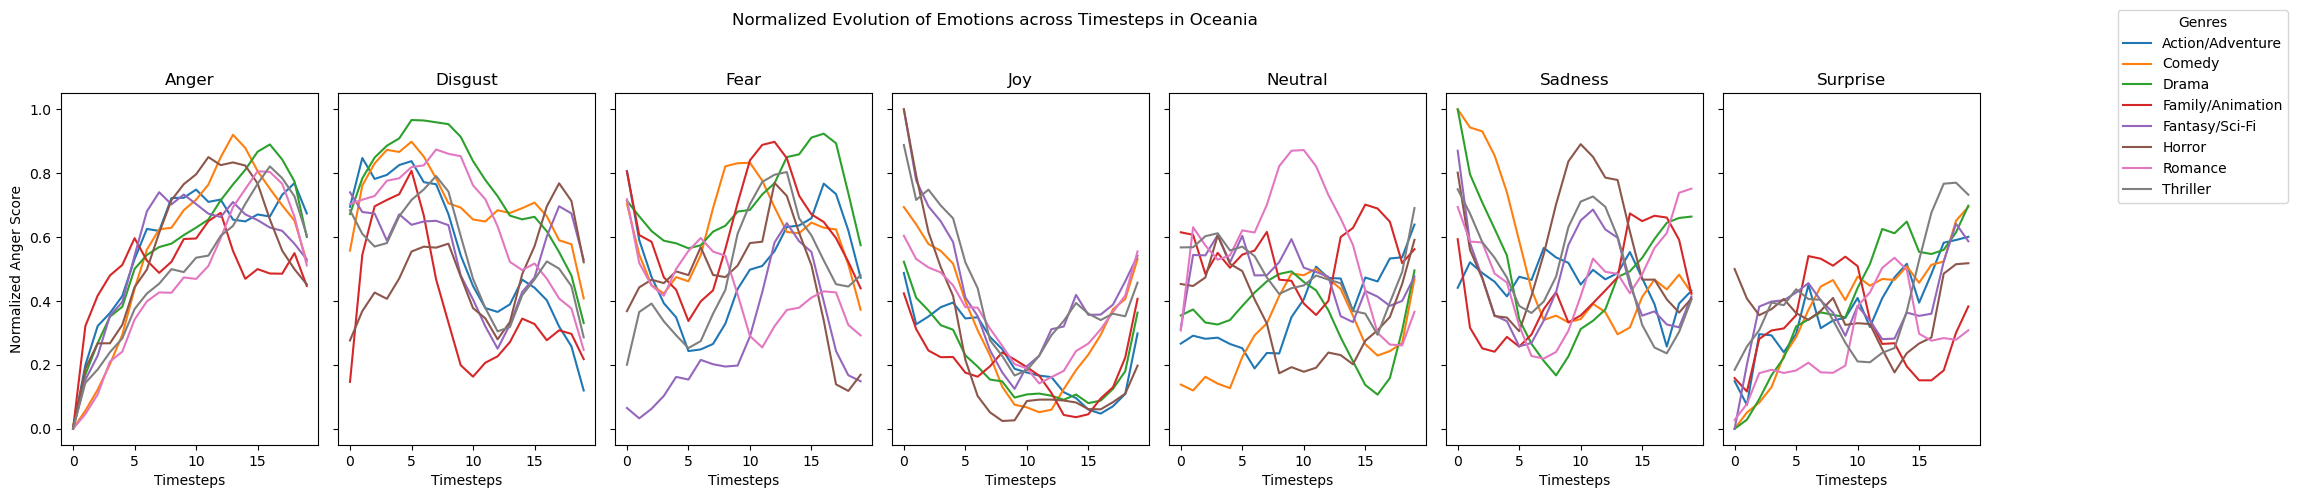

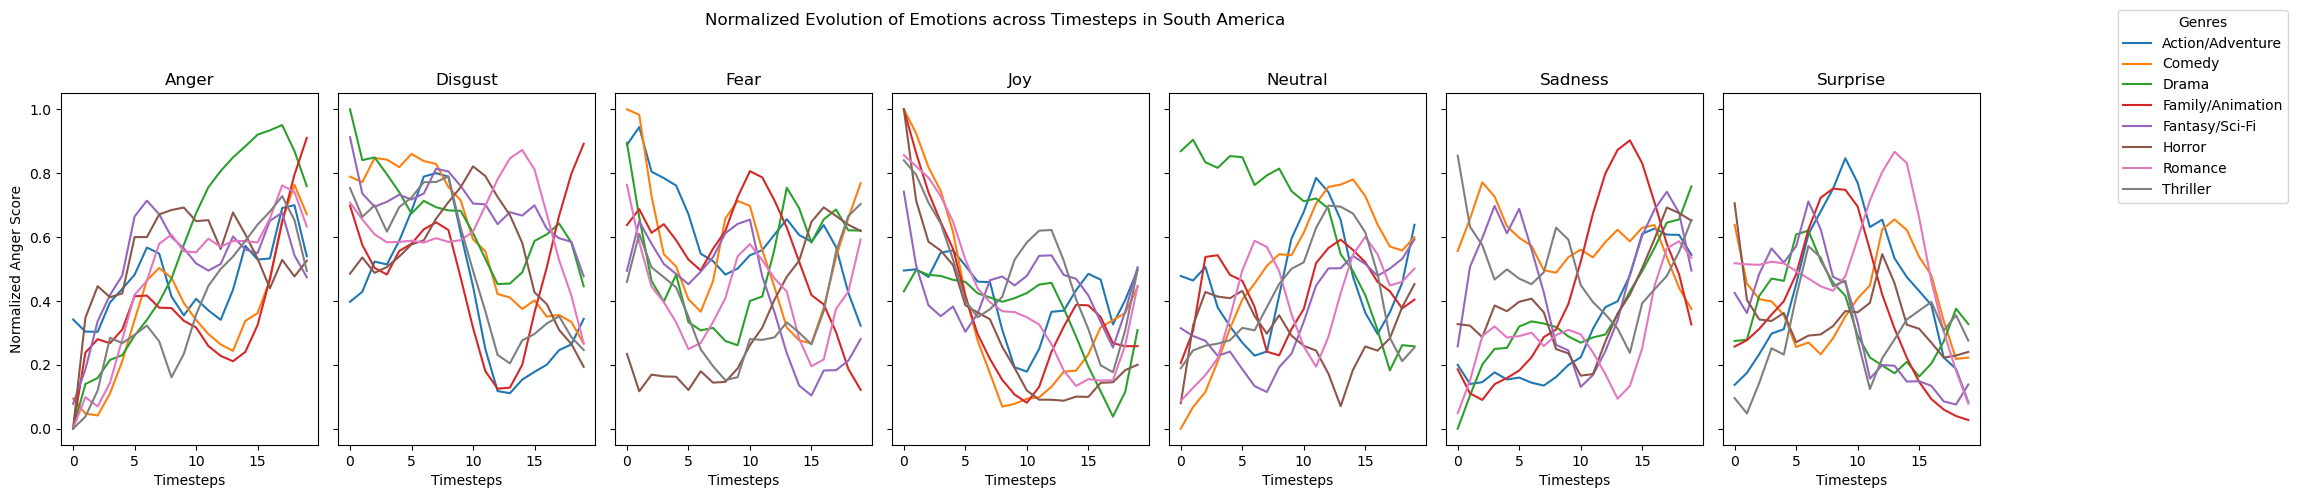

In [9]:
for continent_name, df_continent in zip(continents, dfs):
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps in {continent_name}")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_continent[emotion].unstack(level=0)

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()
        
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns)) 
        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

## Analysis of the Sentiment Arc Before and After Silent Films

#### We'll first focus on the US, the before is gonna be all the movie before 1925 and teh after is only gonna be from 1930 till 1940 to avoid taking the impact of WW2. The colour also appeared it movies around that time, more precisly in 1922.

In [10]:
df_usa = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_usa.shape[0]/20)

df_before_1925 = df_usa[df_usa["Movie_release_date"] < 1922]


# Filter for movies released between 1930 and 1940
df_1930_1940 = df_usa[
    (df_usa["Movie_release_date"] >= 1930) & 
    (df_usa["Movie_release_date"] <= 1940)
]

count_before_1925 = df_usa[df_usa["Movie_release_date"] < 1922].shape[0]
count_1930_1940 = df_usa[(df_usa["Movie_release_date"] >= 1930) & (df_usa["Movie_release_date"] <= 1940)].shape[0]

print(f"Raw count of movies before 1925: {count_before_1925/20}")
print(f"Raw count of movies between 1930 and 1940: {count_1930_1940/20}")

df_before_1925 = df_before_1925.explode("category")
df_1930_1940 = df_1930_1940.explode("category")

df_before_1925 = df_before_1925.groupby(["category", "timestep"])[emotion_columns].mean()
df_1930_1940 = df_1930_1940.groupby(["category", "timestep"])[emotion_columns].mean()




18719.0
Raw count of movies before 1925: 421.0
Raw count of movies between 1930 and 1940: 1121.0


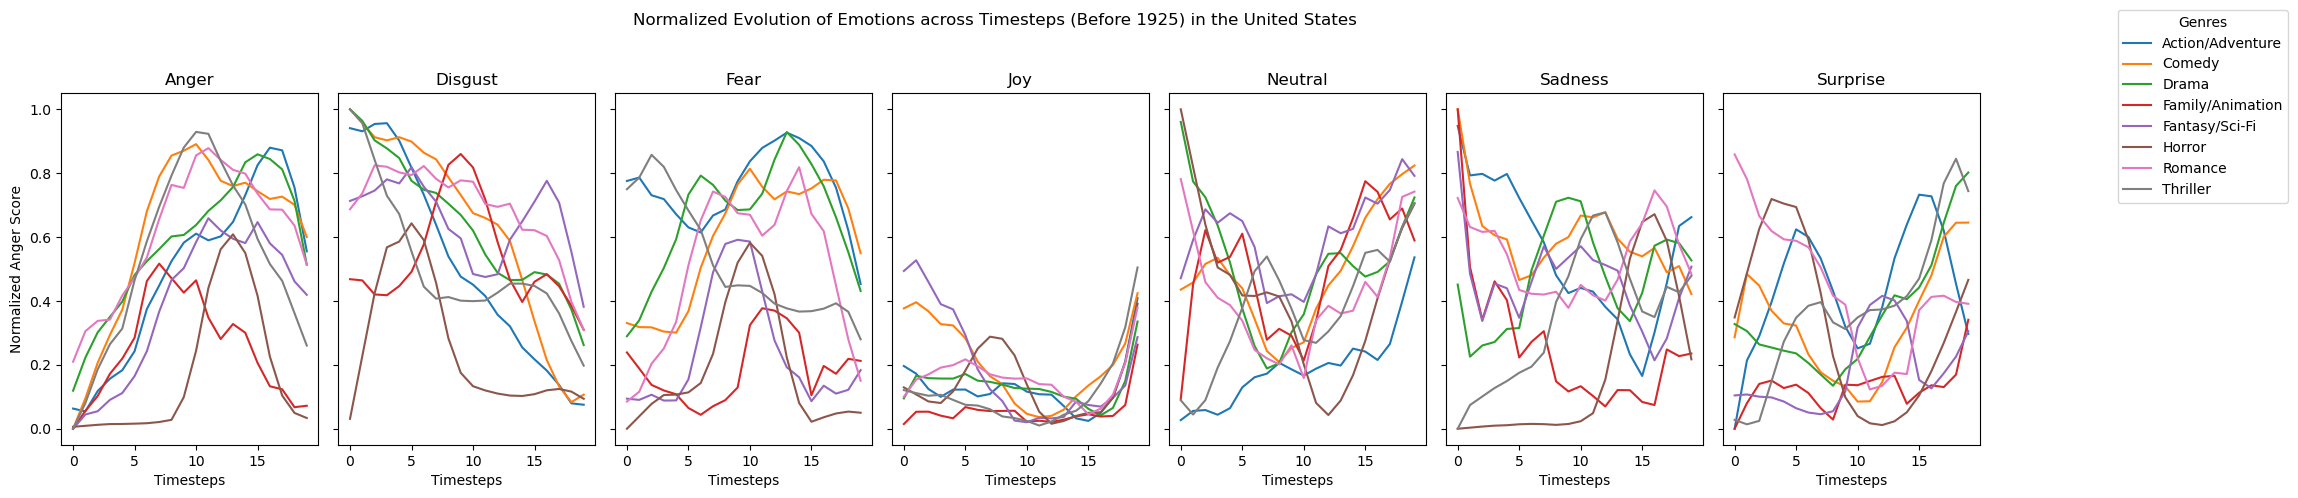

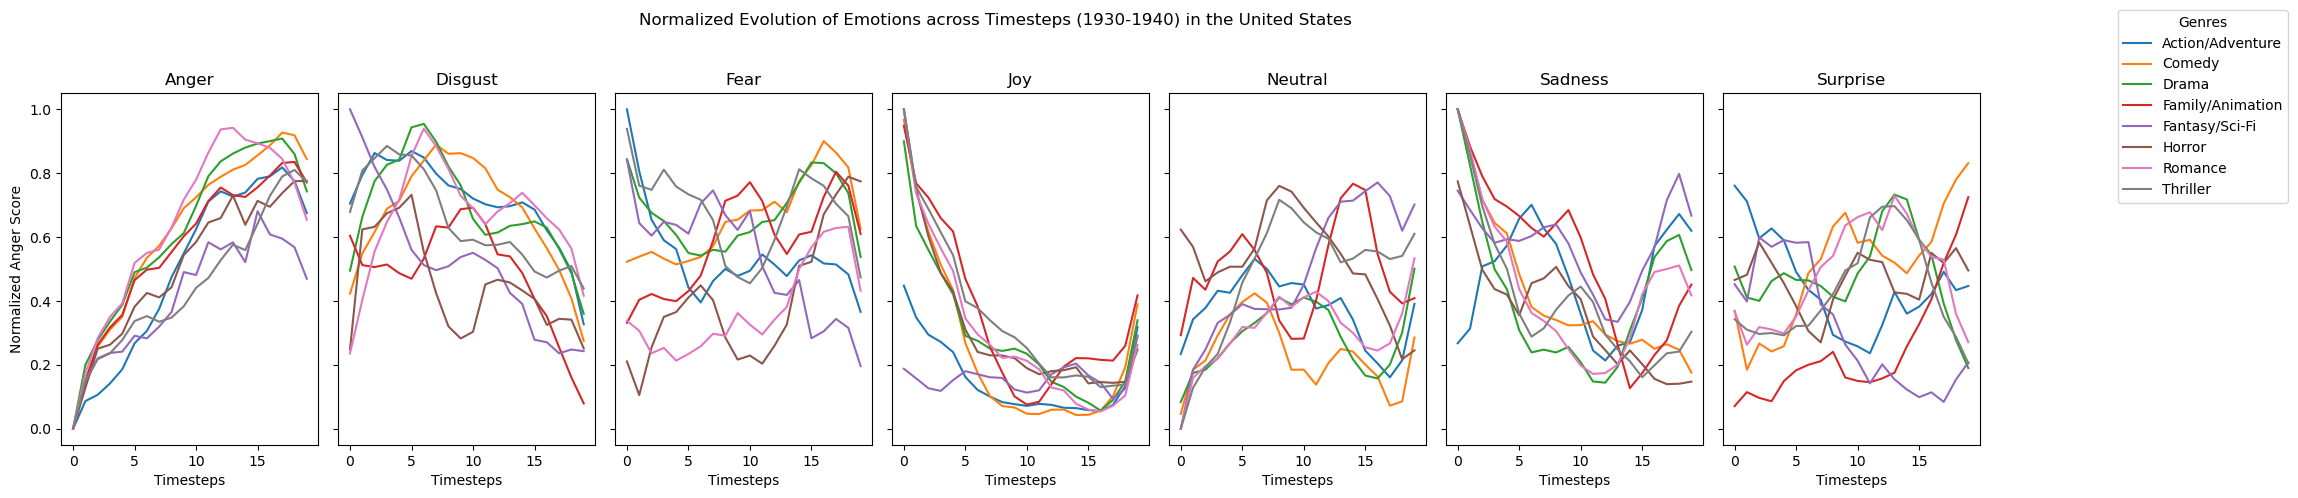

In [11]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 1925": df_before_1925,
    "1930-1940": df_1930_1940
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



bcp plus de joy au debtut du film

### Not divided by genres

In [28]:
df_usa = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_usa.shape[0]/20)

df_before_1922 = df_usa[df_usa["Movie_release_date"] < 1922]


# Filter for movies released between 1930 and 1940
df_1930_1940 = df_usa[
    (df_usa["Movie_release_date"] >= 1930) & 
    (df_usa["Movie_release_date"] <= 1940)
]

count_before_1922 = df_usa[df_usa["Movie_release_date"] < 1922].shape[0]
count_1930_1940 = df_usa[(df_usa["Movie_release_date"] >= 1930) & (df_usa["Movie_release_date"] <= 1940)].shape[0]

print(f"Raw count of movies before 1925: {count_before_1922/20}")
print(f"Raw count of movies between 1930 and 1940: {count_1930_1940/20}")

df_before_1922 = df_before_1922.groupby(["timestep"])[emotion_columns].mean().reset_index()
df_1930_1940 = df_1930_1940.groupby(["timestep"])[emotion_columns].mean().reset_index()

18719.0
Raw count of movies before 1925: 421.0
Raw count of movies between 1930 and 1940: 1121.0


In [31]:
# Define datasets for the two periods
datasets = {
    "Before 1922": df_before_1922,
    "1930-1940": df_1930_1940
}

# Create interactive plots for each dataset, separating graphs by emotions
for period_name, df_period in datasets.items():
    # Create a subplot layout with one row and one column per emotion
    fig = make_subplots(
        rows=1, cols=len(emotion_columns),
        subplot_titles=[emotion.capitalize() for emotion in emotion_columns]
    )

    # Loop through each emotion and plot it on a separate subplot
    for idx, emotion in enumerate(emotion_columns, start=1):
        # Normalize the emotion values across timesteps (min-max normalization)
        normalized_emotion = (df_period[emotion] - df_period[emotion].min()) / (df_period[emotion].max() - df_period[emotion].min())

        # Add a line for the emotion to its respective subplot
        fig.add_trace(
            go.Scatter(
                x=df_period["timestep"],
                y=normalized_emotion,
                mode='lines',
                name=emotion.capitalize(),
                line=dict(width=2)
            ),
            row=1, col=idx
        )

    # Customize the layout
    fig.update_layout(
        title=f"Normalized Evolution of Emotions Across Timesteps ({period_name})",
        height=400,
        width=300 * len(emotion_columns),
        template="plotly_white",
        showlegend=False  # Avoid repeated legends for each subplot
    )

    # Update axis labels
    for idx in range(1, len(emotion_columns) + 1):
        fig.update_xaxes(title_text="Timesteps", col=idx)
        if idx == 1:
            fig.update_yaxes(title_text="Normalized Emotion Score", col=idx)

    # Show the plot
    fig.show()

### data story text

### The Evolution of Emotions in Cinema: A Technological Turning Point

The evolution of emotions in movies before and after pivotal technological milestones reveals a fascinating trend. Our analysis, visualized in the graphs above, shows a marked increase in the presence of **joy** in films from the period of 1930-1940 compared to those made before 1922.

This shift aligns with two groundbreaking innovations in cinema history:

1. **The Advent of Color (1922)**: The introduction of color in films brought a new dimension to storytelling. Vibrant visuals allowed filmmakers to create more engaging and optimistic scenes, making emotions like **joy** more visually impactful and memorable.

2. **The Introduction of Sound (1927)**: The emergence of "talkies" revolutionized the cinematic experience. Music, dialogue, and sound effects enabled movies to convey emotions more dynamically, enhancing the audience's emotional connection to the characters and the story.

These technological advancements likely explain why **joy** becomes more prominent in movies after these milestones. With the ability to combine color and sound, filmmakers could evoke positive emotions with greater intensity and nuance, ushering in a new era of emotionally resonant storytelling.

This analysis underscores how technological progress can influence not only the tools of an art form but also its emotional landscape. As cinema evolved, so did the ways in which emotions were portrayed and experienced.

#### A Potential Shift in Disgust
In addition to joy, we notice a significant change in the portrayal of disgust over time. Disgust appears to be less prominent after 1914 and continues to decline through 1922. This shift warrants further investigation, particularly regarding the impact of World War I (1914–1918) on filmmaking and audience preferences.

The war's devastating global effects may have influenced filmmakers to move away from themes evoking disgust, opting instead for escapist or emotionally complex narratives that resonated with audiences recovering from the trauma of war. This hypothesis invites further exploration into the interplay between historical events and emotional storytelling in cinema.

## Before and after WW1

In [13]:
df_WW1 = df_merged
#[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_WW1.shape[0]/20)

df_before_1914 = df_WW1[df_WW1["Movie_release_date"] < 1914]


# Filter for movies released between 1930 and 1940
df_1914_1925 = df_WW1[
    (df_WW1["Movie_release_date"] >= 1914) & 
    (df_WW1["Movie_release_date"] <= 1925)
]

count_df_before_1914 = df_WW1[df_WW1["Movie_release_date"] < 1915].shape[0]
count_df_1914_1925 = df_WW1[(df_WW1["Movie_release_date"] >= 1915) & (df_WW1["Movie_release_date"] <= 1925)].shape[0]

print(f"Raw count of movies before 1914: {count_df_before_1914/20}")
print(f"Raw count of movies between 1914 and 1925: {count_df_1914_1925/20}")

df_before_1914 = df_before_1914.explode("category")
df_1914_1925 = df_1914_1925.explode("category")

df_before_1914 = df_before_1914.groupby(["category", "timestep"])[emotion_columns].mean()
df_1914_1925 = df_1914_1925.groupby(["category", "timestep"])[emotion_columns].mean()

34342.0
Raw count of movies before 1914: 138.0
Raw count of movies between 1914 and 1925: 524.0


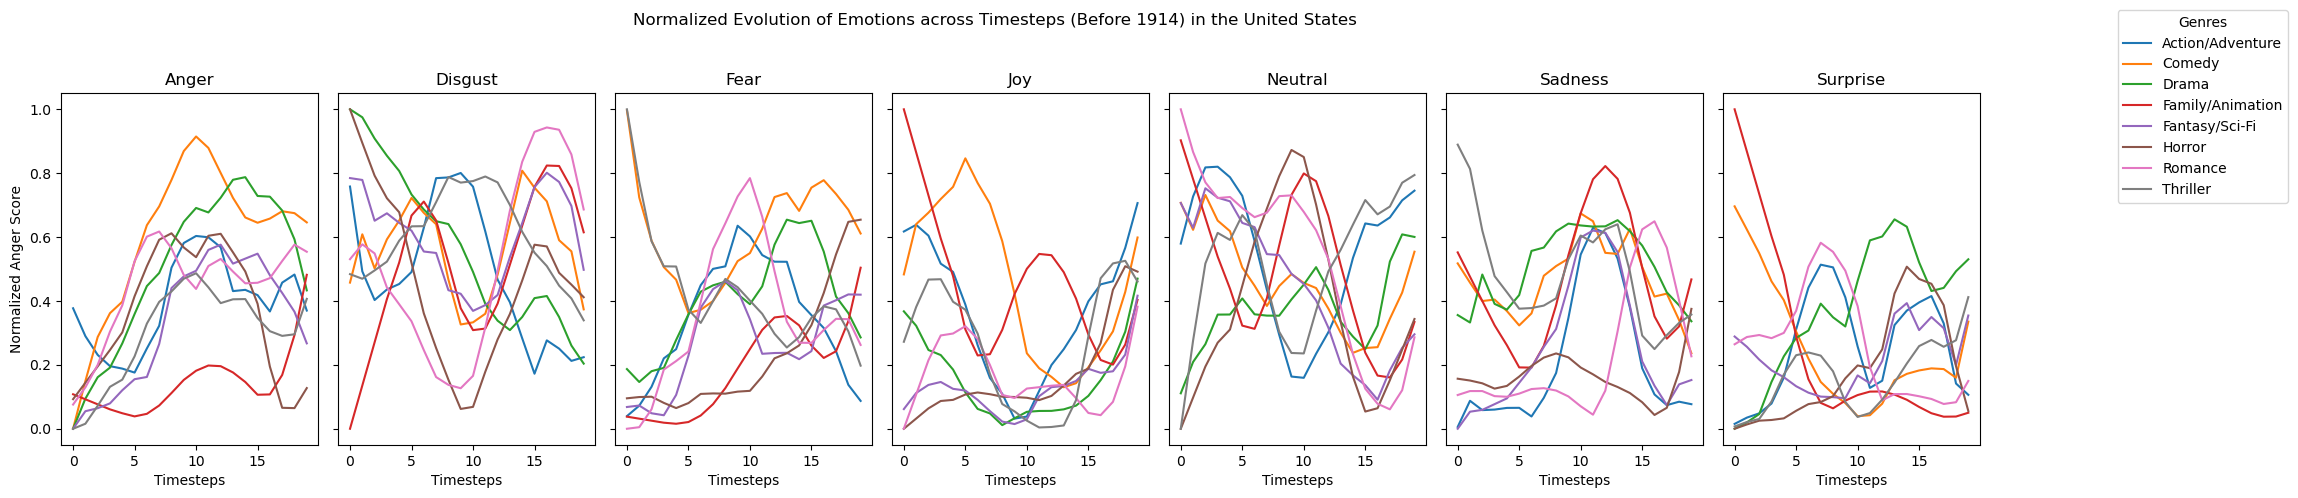

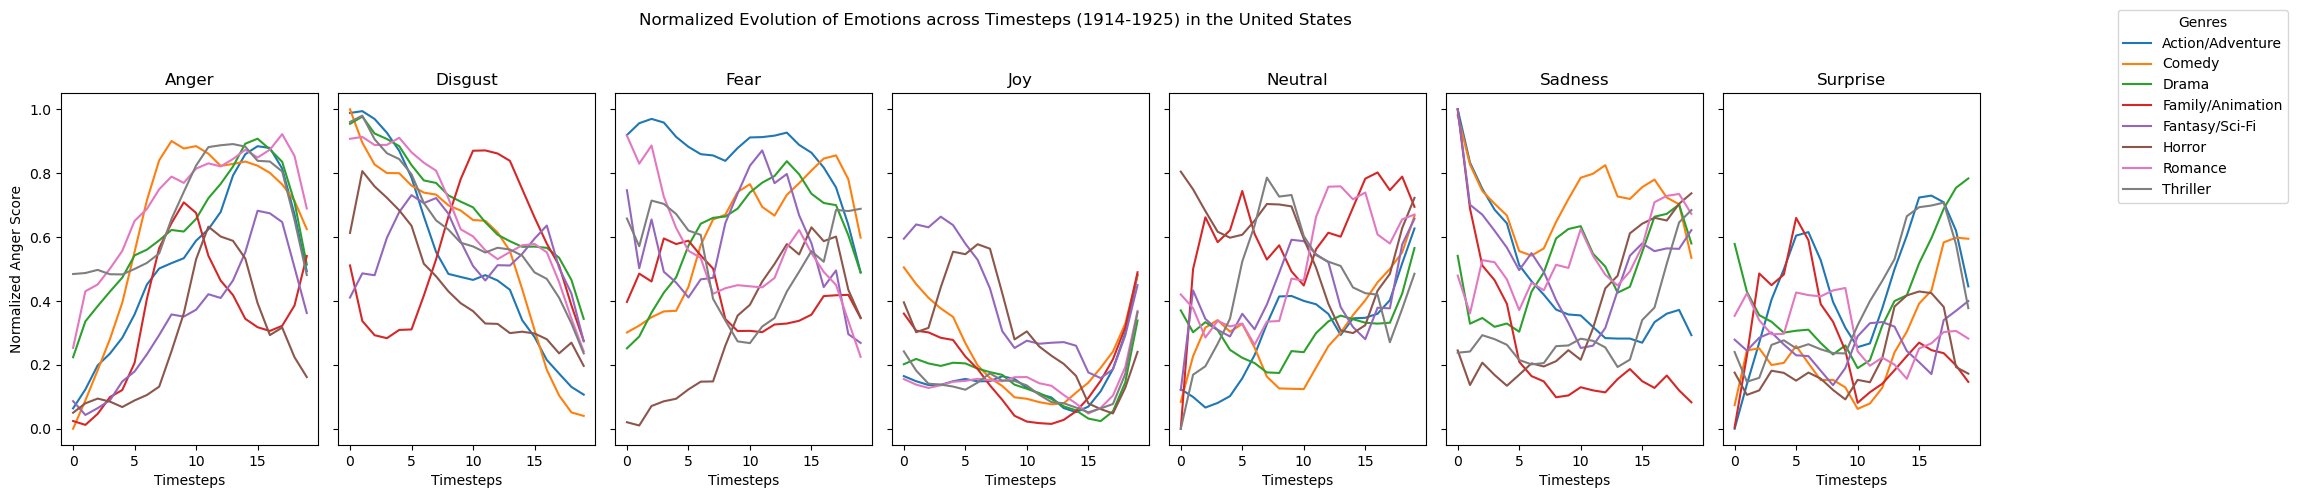

In [14]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 1914": df_before_1914,
    "1914-1925": df_1914_1925
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



plus de fear, moins de joy et plus de sadness cste tt le long du film, entre 1914 et 1925 partt dans le monde

### not divided per genres

In [32]:
df_WW1 = df_merged
#[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_WW1.shape[0]/20)

df_before_1914 = df_WW1[df_WW1["Movie_release_date"] < 1914]


# Filter for movies released between 1930 and 1940
df_1914_1922 = df_WW1[
    (df_WW1["Movie_release_date"] >= 1914) & 
    (df_WW1["Movie_release_date"] <= 1922)
]

count_df_before_1914 = df_WW1[df_WW1["Movie_release_date"] < 1915].shape[0]
count_df_1914_1922 = df_WW1[(df_WW1["Movie_release_date"] >= 1915) & (df_WW1["Movie_release_date"] <= 1922)].shape[0]

print(f"Raw count of movies before 1914: {count_df_before_1914/20}")
print(f"Raw count of movies between 1914 and 1925: {count_df_1914_1922/20}")

df_before_1914 = df_before_1914.groupby([ "timestep"])[emotion_columns].mean().reset_index()
df_1914_1922 = df_1914_1922.groupby([ "timestep"])[emotion_columns].mean().reset_index()

34342.0
Raw count of movies before 1914: 138.0
Raw count of movies between 1914 and 1925: 373.0


In [33]:
# Define datasets for the two periods
datasets = {
    "Before 1914": df_before_1914,
    "1914-1922": df_1914_1922
}

# Create interactive plots for each dataset, separating graphs by emotions
for period_name, df_period in datasets.items():
    # Create a subplot layout with one row and one column per emotion
    fig = make_subplots(
        rows=1, cols=len(emotion_columns),
        subplot_titles=[emotion.capitalize() for emotion in emotion_columns]
    )

    # Loop through each emotion and plot it on a separate subplot
    for idx, emotion in enumerate(emotion_columns, start=1):
        # Normalize the emotion values across timesteps (min-max normalization)
        normalized_emotion = (df_period[emotion] - df_period[emotion].min()) / (df_period[emotion].max() - df_period[emotion].min())

        # Add a line for the emotion to its respective subplot
        fig.add_trace(
            go.Scatter(
                x=df_period["timestep"],
                y=normalized_emotion,
                mode='lines',
                name=emotion.capitalize(),
                line=dict(width=2)
            ),
            row=1, col=idx
        )

    # Customize the layout
    fig.update_layout(
        title=f"Normalized Evolution of Emotions Across Timesteps ({period_name})",
        height=400,
        width=300 * len(emotion_columns),
        template="plotly_white",
        showlegend=False  # Avoid repeated legends for each subplot
    )

    # Update axis labels
    for idx in range(1, len(emotion_columns) + 1):
        fig.update_xaxes(title_text="Timesteps", col=idx)
        if idx == 1:
            fig.update_yaxes(title_text="Normalized Emotion Score", col=idx)

    # Show the plot
    fig.show()

#### DATA STORY

### The Decline of Disgust: How World War I Shaped Early Cinema  

The emotion of **disgust** takes a dramatic turn in early cinema. Before 1914, it featured prominently in films, but as **World War I** unfolded, its presence faded, continuing to decline through the 1914–1922 period. This shift reveals the deep impact of global trauma on storytelling.  

#### A Shift Away From Discomfort  
The war brought violence, suffering, and loss on an unprecedented scale. Audiences already burdened by these realities had little appetite for films evoking disgust. Filmmakers responded by moving toward narratives of hope and escapism, leaving behind themes tied to discomfort or grotesque imagery.  

#### Simplicity and Constraints  
The war also placed practical constraints on filmmaking. With limited resources, productions became simpler, leaving less room for the detailed visual effects often used to portray disgust.  

### A Society in Healing  
The decline of disgust reflects a society seeking solace in cinema. As audiences healed, so did the emotional tones of films, moving away from harsh reminders of the horrors they endured. This transformation invites us to explore how cinema adapts not only to technological progress but also to the emotional pulse of its time.  

## Before and after WW2

In [40]:
df_WW2 = df_merged
#[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_WW2.shape[0]/20)

df_before_1940 = df_WW2[
    (df_WW2["Movie_release_date"] >= 1930) & 
    (df_WW2["Movie_release_date"] <= 1940)
]


# Filter for movies released between 1930 and 1940
df_1940_1950 = df_WW2[
    (df_WW2["Movie_release_date"] >= 1940) & 
    (df_WW2["Movie_release_date"] <= 1950)
]

count_df_before_1940 = df_WW2[df_WW2["Movie_release_date"] < 1940].shape[0]
count_df_1940_1950 = df_WW2[(df_WW2["Movie_release_date"] >= 1940) & (df_WW2["Movie_release_date"] <= 1950)].shape[0]

print(f"Raw count of movies before 1914: {count_df_before_1940/20}")
print(f"Raw count of movies between 1914 and 1925: {count_df_1940_1950/20}")

df_before_1940 = df_before_1940.groupby(["timestep"])[emotion_columns].mean().reset_index()
df_1940_1950 = df_1940_1950.groupby([ "timestep"])[emotion_columns].mean().reset_index()

34342.0
Raw count of movies before 1914: 1991.0
Raw count of movies between 1914 and 1925: 1294.0


In [41]:
# Define datasets for the two periods
datasets = {
    "Before 1940": df_before_1940,
    "1940-1945": df_1940_1950
}

# Create interactive plots for each dataset, separating graphs by emotions
for period_name, df_period in datasets.items():
    # Create a subplot layout with one row and one column per emotion
    fig = make_subplots(
        rows=1, cols=len(emotion_columns),
        subplot_titles=[emotion.capitalize() for emotion in emotion_columns]
    )

    # Loop through each emotion and plot it on a separate subplot
    for idx, emotion in enumerate(emotion_columns, start=1):
        # Normalize the emotion values across timesteps (min-max normalization)
        normalized_emotion = (df_period[emotion] - df_period[emotion].min()) / (df_period[emotion].max() - df_period[emotion].min())

        # Add a line for the emotion to its respective subplot
        fig.add_trace(
            go.Scatter(
                x=df_period["timestep"],
                y=normalized_emotion,
                mode='lines',
                name=emotion.capitalize(),
                line=dict(width=2)
            ),
            row=1, col=idx
        )

    # Customize the layout
    fig.update_layout(
        title=f"Normalized Evolution of Emotions Across Timesteps ({period_name})",
        height=400,
        width=300 * len(emotion_columns),
        template="plotly_white",
        showlegend=False  # Avoid repeated legends for each subplot
    )

    # Update axis labels
    for idx in range(1, len(emotion_columns) + 1):
        fig.update_xaxes(title_text="Timesteps", col=idx)
        if idx == 1:
            fig.update_yaxes(title_text="Normalized Emotion Score", col=idx)

    # Show the plot
    fig.show()

pas bcp de changement

## Impact 9/11

In [ ]:
df_911 = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_911.shape[0]/20)

df_before_911 = df_911[
    (df_911["Movie_release_date"] >= 1998) & 
    (df_911["Movie_release_date"] <= 2000)
]


# Filter for movies released between 1930 and 1940
df_after_911 = df_911[
    (df_911["Movie_release_date"] >= 2001) & 
    (df_911["Movie_release_date"] <= 2003)
]

count_before_911 = df_911[(df_911["Movie_release_date"] >= 1995) & (df_911["Movie_release_date"] <= 2000)].shape[0]
count_df_after_911 = df_911[(df_911["Movie_release_date"] >= 2001) & (df_911["Movie_release_date"] <= 2005)].shape[0]

print(f"Raw count of movies before 9/11: {count_before_911/20}")
print(f"Raw count of movies after 9/11: {count_df_after_911/20}")

df_before_911 = df_before_911.explode("category")
df_after_911 = df_after_911.explode("category")

df_before_911 = df_before_911.groupby(["category", "timestep"])[emotion_columns].mean()
df_after_911 = df_after_911.groupby(["category", "timestep"])[emotion_columns].mean()



18719.0
Raw count of movies before 9/11: 1381.0
Raw count of movies after 9/11: 1427.0


anger   disgust      fear       joy   neutral  \
category         timestep                                                     
Action/Adventure 0         0.109778  0.162931  0.148273  0.110499  0.322220   
                 1         0.136350  0.168929  0.127108  0.057378  0.340450   
                 2         0.147444  0.162617  0.121534  0.055165  0.363388   
                 3         0.149667  0.144601  0.134236  0.069762  0.353526   
                 4         0.145998  0.171293  0.114191  0.047365  0.350586   

                            sadness  surprise  
category         timestep                      
Action/Adventure 0         0.110545  0.035755  
                 1         0.129192  0.040593  
                 2         0.112681  0.037171  
                 3         0.112079  0.036129  
                 4         0.124673  0.045894

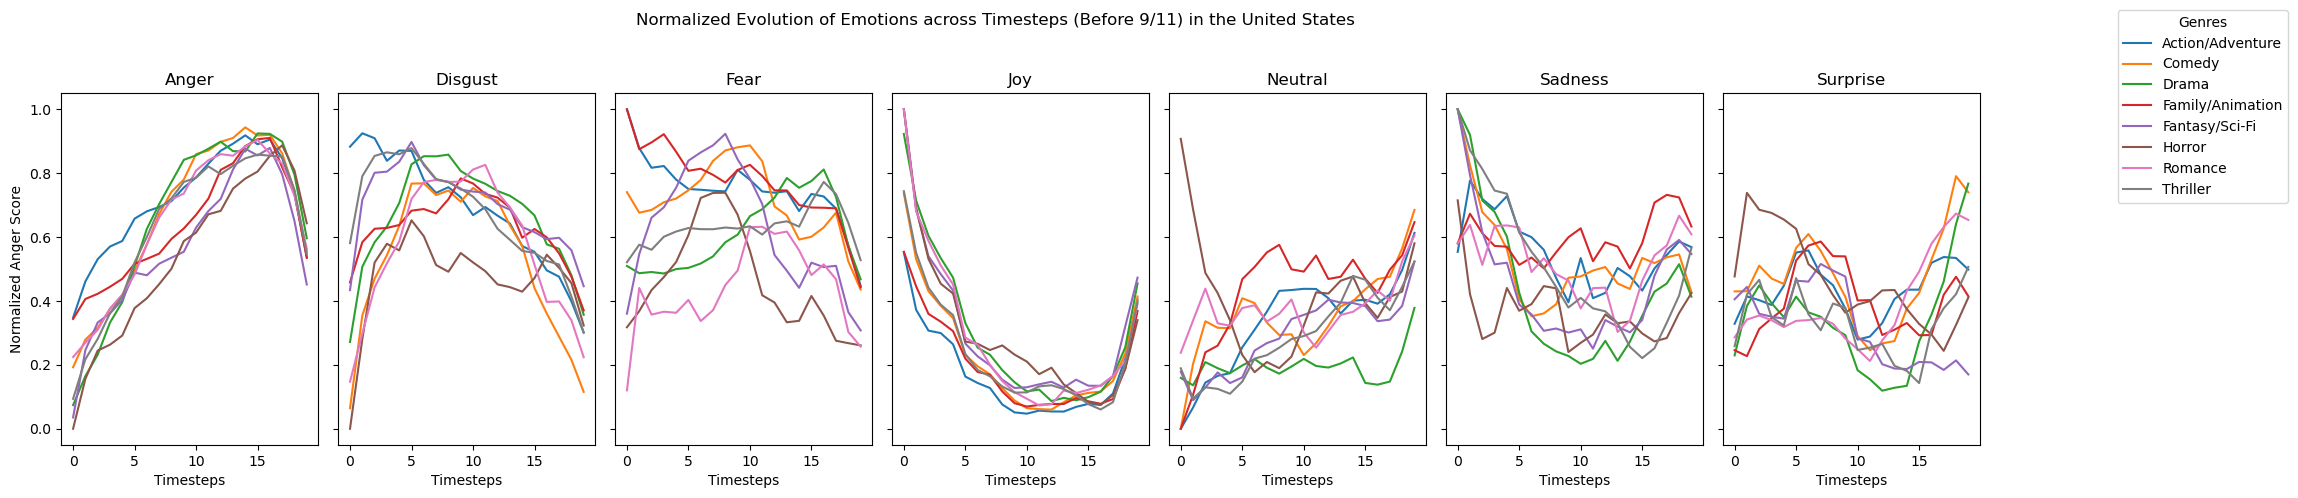

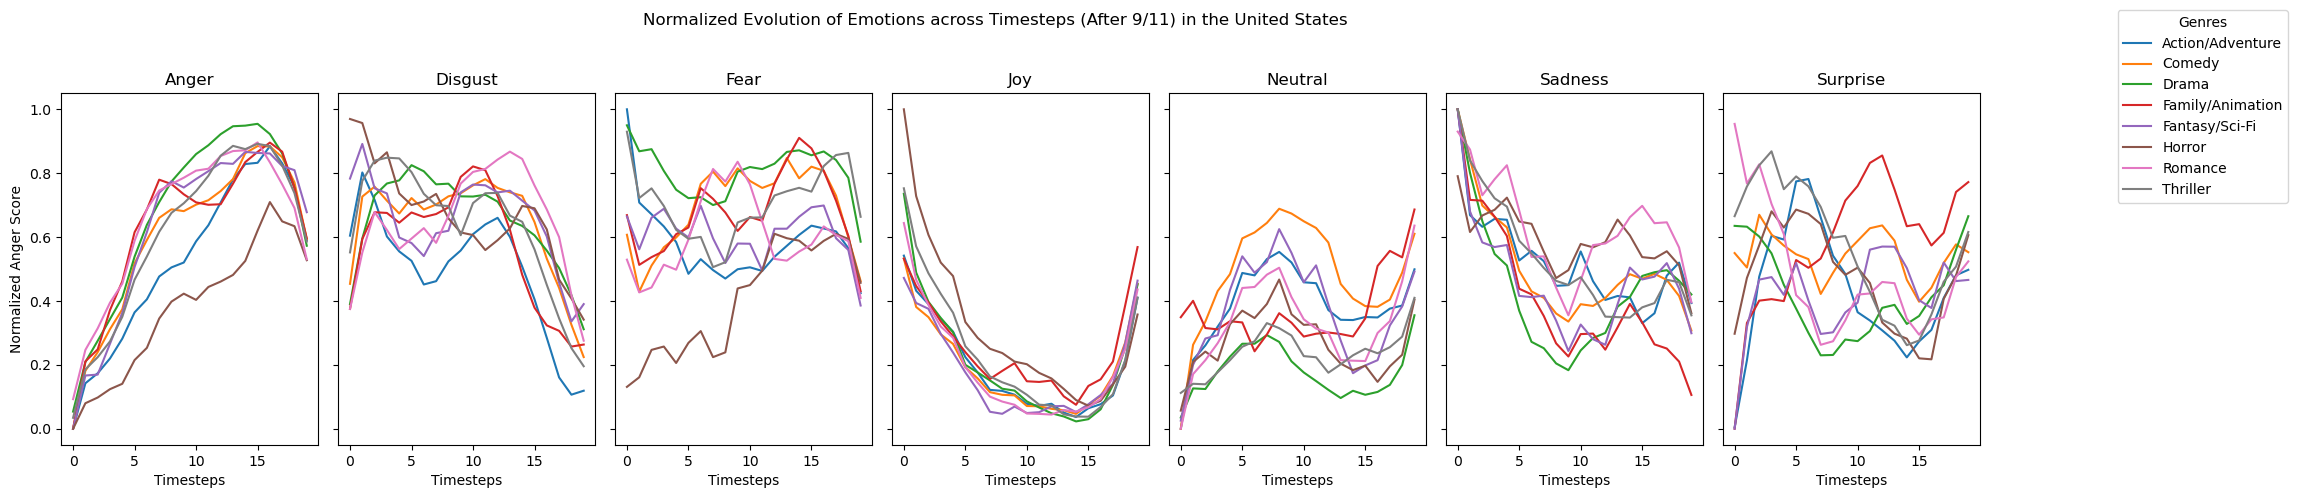

In [48]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 9/11": df_before_911,
    "After 9/11": df_after_911
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



un peu plus de sadness surtt pour les romances a la fin du film, la surpise varie plus au cours du film apres ( du surement au sentimental arc qui devient une recette  bien precise) 

anlayse interreessante, regarder quels films de romances apres 9/11 pour voir si certain sont connu et traite de cet evenement la 

In [56]:
# Update the datasets to include only "Romance" and "Family/Animation" for "Sadness"
categories_of_interest = ["Romance", "Family/Animation"]
emotion_of_interest = "sadness"

datasets = {
    "Before 9/11": df_before_911,
    "After 9/11": df_after_911
}


for period_name, df_period in datasets.items():
    # Filter and normalize data for the selected categories
    filtered_data = df_period.loc[categories_of_interest, emotion_of_interest].reset_index()
    pivoted_data = filtered_data.pivot(index="timestep", columns="category", values=emotion_of_interest)

    # Normalize values for each category
    normalized_data = pivoted_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

    # Create a plotly figure
    fig = go.Figure()
    for genre in categories_of_interest:
        fig.add_trace(go.Scatter(
            x=normalized_data.index,
            y=normalized_data[genre],
            mode='lines',
            name=genre
        ))

    # Update layout for the figure
    fig.update_layout(
        title=f"Normalized Evolution of Sadness in {categories_of_interest} ({period_name})",
        xaxis_title="Timesteps",
        yaxis_title="Normalized Sadness Score",
        legend_title="Genres",
        template="plotly_white",
        height=500,
        width=800
    )

    # Show the plot
    fig.show()

#### DATA STORY

### The Diverging Faces of Sadness in Cinema After 9/11  

The emotional trajectory of sadness in cinema tells a story of adaptation and purpose, with two genres—**family/animation** and **romance**—charting distinct paths after 9/11.  

Before the attacks, sadness followed relatively consistent patterns across genres. But as the world grappled with collective grief, filmmakers responded differently, depending on their audience. The result? A **drop in sadness** for family and animated films but a **rise** in romance, reflecting the emotional needs of a society in recovery.  


#### Family/Animation: A Retreat From Sadness  

For family and animated films, sadness declines sharply in the post-9/11 period. This genre, often a source of comfort for younger audiences, shifted its focus toward **optimistic and uplifting stories**. The drop in sadness could reflect a conscious effort by creators to shield audiences from heavy emotional themes, offering escapism instead of reminders of real-world grief.  

Films in this genre may have leaned into narratives of resilience, hope, and connection—messages that reassured viewers, both young and old, in uncertain times.  


#### Romance: Leaning Into Sadness  

In contrast, romance films embraced sadness, with the emotion becoming more prominent post-9/11. This genre, defined by themes of love, loss, and vulnerability, may have provided a space for audiences to process their feelings.  

As people sought to make sense of their own emotional experiences, romance films likely resonated by offering **catharsis** through stories that explored longing, heartbreak, and human connection. In this way, the rise of sadness in romance reflects cinema’s ability to mirror society’s deeper emotional currents.  


#### Two Genres, Two Roles  

The contrasting paths of sadness in family/animation and romance highlight cinema’s **dual role** after 9/11:  

- **Comfort and escape** for some, where lighthearted and hopeful stories offered a reprieve.  
- **Reflection and catharsis** for others, where emotional depth helped viewers process grief and loss.  

This divergence reveals how storytelling adapts to serve different emotional needs, providing solace for one audience while giving another the space to feel and heal.  

As we continue to explore cinema's evolving emotional landscape, these trends offer a poignant reminder of its power to shape, and be shaped by, the times we live in.  

In [49]:
df_911 = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_911.shape[0]/20)

df_before_911 = df_911[
    (df_911["Movie_release_date"] >= 1998) & 
    (df_911["Movie_release_date"] <= 2000)
]


# Filter for movies released between 1930 and 1940
df_after_911 = df_911[
    (df_911["Movie_release_date"] >= 2001) & 
    (df_911["Movie_release_date"] <= 2003)
]

count_before_911 = df_911[(df_911["Movie_release_date"] >= 1995) & (df_911["Movie_release_date"] <= 2000)].shape[0]
count_df_after_911 = df_911[(df_911["Movie_release_date"] >= 2001) & (df_911["Movie_release_date"] <= 2005)].shape[0]

print(f"Raw count of movies before 9/11: {count_before_911/20}")
print(f"Raw count of movies after 9/11: {count_df_after_911/20}")

df_before_911 = df_before_911.groupby(["timestep"])[emotion_columns].mean().reset_index()
df_after_911 = df_after_911.groupby(["timestep"])[emotion_columns].mean().reset_index()

18719.0
Raw count of movies before 9/11: 1381.0
Raw count of movies after 9/11: 1427.0


In [50]:
# Define datasets for the two periods
datasets = {
    "Before 9/11": df_before_911,
    "After 9/11": df_after_911
}

# Create interactive plots for each dataset, separating graphs by emotions
for period_name, df_period in datasets.items():
    # Create a subplot layout with one row and one column per emotion
    fig = make_subplots(
        rows=1, cols=len(emotion_columns),
        subplot_titles=[emotion.capitalize() for emotion in emotion_columns]
    )

    # Loop through each emotion and plot it on a separate subplot
    for idx, emotion in enumerate(emotion_columns, start=1):
        # Normalize the emotion values across timesteps (min-max normalization)
        normalized_emotion = (df_period[emotion] - df_period[emotion].min()) / (df_period[emotion].max() - df_period[emotion].min())

        # Add a line for the emotion to its respective subplot
        fig.add_trace(
            go.Scatter(
                x=df_period["timestep"],
                y=normalized_emotion,
                mode='lines',
                name=emotion.capitalize(),
                line=dict(width=2)
            ),
            row=1, col=idx
        )

    # Customize the layout
    fig.update_layout(
        title=f"Normalized Evolution of Emotions Across Timesteps ({period_name})",
        height=400,
        width=300 * len(emotion_columns),
        template="plotly_white",
        showlegend=False  # Avoid repeated legends for each subplot
    )

    # Update axis labels
    for idx in range(1, len(emotion_columns) + 1):
        fig.update_xaxes(title_text="Timesteps", col=idx)
        if idx == 1:
            fig.update_yaxes(title_text="Normalized Emotion Score", col=idx)

    # Show the plot
    fig.show()